In [1]:
# kitti는 Autunomous Driving을 위한 유명한 Test Dataset이다
# https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb 에서 발췌

In [2]:
import torch
print(torch.__version__)

1.12.1+cu113


In [3]:
# 이 전체가 mmDetection을 설치하는 코드이다
# https://mmcv.readthedocs.io/en/latest/get_started/installation.html 설치 과정 참조.  
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html

# MMDetection설치하는 과정
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 40.6 MB 18.1 MB/s 
     |████████████████████████████████| 190 kB 29.1 MB/s 
Cloning into 'mmdetection'...
remote: Enumerating objects: 29242, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 29242 (delta 30), reused 46 (delta 15), pack-reused 29131
Receiving objects: 100% (29242/29242), 39.67 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (20879/20879), done.
running install
running bdist_egg
running egg_info
creating mmdet.egg-info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
writing manifest file 'mmdet.egg-info/SOURCES.txt'
reading man

In [1]:
# mmcv를 설치하였으니, 아래를 수행하기 전에 kernel을 restart 해야 함. 
from mmdet.apis import init_detector, inference_detector
import mmcv

### KITTI Dataset 다운로드
* 작은 용량의 KITTI Dataset을 다운로드하고 /content 밑에 압축 해제

In [2]:
# 원래 kitti Dataset의 용량은 매우 크다
# 하지만 mmDetection의 Tutorial용도로 소형화된 Dataset을 이용할 것이다
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-08-16 14:56:08--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 161.117.242.73
Connecting to download.openmmlab.com (download.openmmlab.com)|161.117.242.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  18.5MB/s    in 0.4s    

2022-08-16 14:56:09 (18.5 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



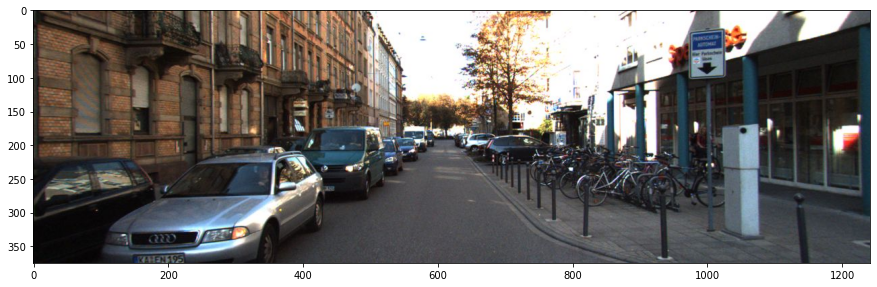

In [3]:
import matplotlib.pyplot as plt
import cv2

# 하나의 train Image를 선택하여 출력해본다
img = cv2.cvtColor(cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)

### KITTI DATA FORMAT 확인
* 첫번째 컬럼은 해당 오브젝트의 클래스 명. 
* 5번째~8번째가 BOUNDING BOX 정보임. 좌상단(xmin, ymin), 우하단(xmax, ymax) 좌표 임. 

In [4]:
# 000068.jpg의 annotation file읽기
!cat /content/kitti_tiny/training/label_2/000068.txt

Car 0.25 0 1.94 69.26 200.28 435.08 374.00 1.46 1.62 4.04 -3.00 1.79 6.98 1.55
Car 0.80 1 2.26 0.00 209.20 198.59 374.00 1.46 1.58 3.72 -5.44 1.85 6.22 1.56
Cyclist 0.97 0 2.34 1210.28 199.77 1241.00 374.00 1.55 0.57 1.73 4.04 1.69 3.57 -3.14
Car 0.00 2 1.68 478.18 187.68 549.54 249.43 1.57 1.60 3.99 -2.73 2.03 20.96 1.55
Car 0.00 1 1.66 530.03 187.79 573.10 226.09 1.52 1.54 3.68 -2.53 2.20 31.50 1.58
Van 0.00 1 1.63 547.61 171.12 584.05 212.41 2.47 1.98 5.81 -2.79 2.41 46.44 1.57
Car 0.00 1 -0.16 667.74 182.35 790.82 230.38 1.62 1.65 4.14 4.19 1.99 25.95 0.00
Car 0.00 2 -0.11 657.37 184.48 763.34 221.64 1.55 1.66 4.47 4.35 2.10 32.00 0.02
Car 0.00 1 -0.01 637.45 180.34 714.44 212.34 1.69 1.76 4.12 3.59 2.12 39.79 0.08
Van 0.00 1 1.61 572.52 175.02 596.26 199.95 2.13 1.91 6.40 -2.28 2.36 65.43 1.57
Van 0.00 1 1.77 380.78 167.69 523.29 288.56 1.95 1.75 4.63 -2.89 1.90 14.05 1.57
Cyclist 0.00 1 1.09 958.95 167.55 1036.88 254.43 1.68 0.53 1.96 7.95 1.59 14.95 1.57


\### KITTI annotation 파일들의 리스트가 작성된 파일을 출력해보자 

In [5]:
# 전체 데이터들 중 어느 것이 train data에 사용될 이미지인지 정보가 적혀있는 파일이다
!cat /content/kitti_tiny/train.txt

000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049


### mmdetection의 중립 annotation 포맷 변환. 해당 포맷은 텍스트로 변환하지 않음. 바로 메모리 상의 list로 생성됨.  
#### filename, width, height, ann을 Key로 가지는 Dictionary를 이미지 개수대로 가지는 list 생성. 
* filename: 이미지 파일명(디렉토리는 포함하지 않음)
* width: 이미지 너비
* height: 이미지 높이
* ann: bbounding box와 label에 대한 정보를 가지는 Dictionary
 - bboxes: 하나의 이미지에 있는 여러 Object 들의 numpy array. 4개의 좌표값(좌상단, 우하단)을 가지고, 해당 이미지에 n개의 Object들이 있을 경우 array의 shape는 (n, 4)
 - labels: 하나의 이미지에 있는 여러 Object들의 numpy array. shape는 (n, )
 - bboxes_ignore: 학습에 사용되지 않고 무시하는 bboxes. 무시하는 bboxes의 개수가 k개이면 shape는 (k, 4)
 - labels_ignore: 학습에 사용되지 않고 무시하는 labels. 무시하는 bboxes의 개수가 k개이면 shape는 (k,)



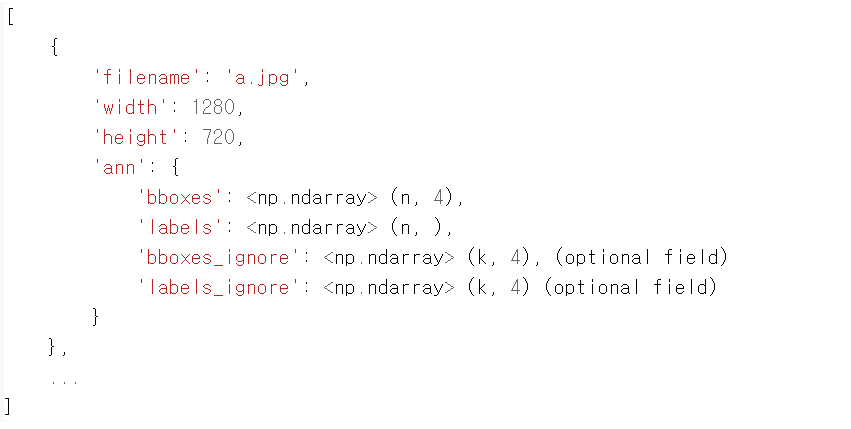

### kitti Dataset을 중립 데이터형태(Middle Data 형태) 로 변환하여 메모리 로드

In [6]:
# 원본 kitti Dataset는 10개의 Class로 되어 있음. 'Car Van Truck Pedestrian Person_sitting Cyclist Tram Misc DontCare'
# 원래는 10개이지만 우리는 4개의 Class만 이용할 것이다
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}
print(cat2label)
cat2label['Car']


{'Car': 0, 'Truck': 1, 'Pedestrian': 2, 'Cyclist': 3}


0

In [7]:
# train data에 사용될 이미지의 목록을 불러와 list로 만든다
image_list = mmcv.list_from_file('/content/kitti_tiny/train.txt')

In [9]:
# 해당 000064.jpg의 annotation file을 parsing하는 code이다
# \n 개행단위로 끊어와 list로 만든다 > 즉, 이미지에 담긴 object별로 한 줄에 기재되어 있으니, object 개수만큼의 element가 된다
lines = mmcv.list_from_file('/content/kitti_tiny/training/label_2/000064.txt')
print(lines)

# object별 정보를 공백단위로 split하여 별개의 list로 제작
content = [line.strip().split(' ') for line in lines]
print(content)

# content각 원소의 첫 번째가 바로 object의 class명을 의미한다
bbox_names = [x[0] for x in content]
print(bbox_names)

# content각 원소의 4,5,6,7번째가 바로 object의 bbox 좌표들을 의미한다
bboxes = [ [float(info) for info in x[4:8]] for x in content]
print(bboxes)

['Car 0.00 0 -1.70 657.65 179.93 709.86 219.92 1.38 1.49 3.32 2.65 1.65 26.82 -1.60', 'Car 0.00 0 -1.85 731.51 180.39 882.28 275.80 1.50 1.62 3.89 3.43 1.65 13.46 -1.60', 'Car 0.00 1 -1.83 715.18 175.63 762.77 203.90 1.44 1.56 3.96 6.91 1.61 39.17 -1.65', 'Truck 0.00 1 -2.01 816.58 59.74 1112.51 266.07 3.55 2.56 7.97 7.25 1.64 16.44 -1.60', 'DontCare -1 -1 -10 626.78 174.27 647.77 192.18 -1 -1 -1 -1000 -1000 -1000 -10', 'DontCare -1 -1 -10 546.19 168.97 554.01 177.09 -1 -1 -1 -1000 -1000 -1000 -10']
[['Car', '0.00', '0', '-1.70', '657.65', '179.93', '709.86', '219.92', '1.38', '1.49', '3.32', '2.65', '1.65', '26.82', '-1.60'], ['Car', '0.00', '0', '-1.85', '731.51', '180.39', '882.28', '275.80', '1.50', '1.62', '3.89', '3.43', '1.65', '13.46', '-1.60'], ['Car', '0.00', '1', '-1.83', '715.18', '175.63', '762.77', '203.90', '1.44', '1.56', '3.96', '6.91', '1.61', '39.17', '-1.65'], ['Truck', '0.00', '1', '-2.01', '816.58', '59.74', '1112.51', '266.07', '3.55', '2.56', '7.97', '7.25', '1.

In [17]:
# 우리가 가진 데이터를 받아서 middle data format으로 변환시켜주는 CustomDataset을 정의한다

import copy
import os.path as osp
import cv2

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# 반드시 아래 Decorator 설정 할것
# @DATASETS.register_module() 설정 시 force=True를 입력하지 않으면 Dataset 재등록 불가.
# CustomDataset객체를 mmDetection FrameWork에 등록한다

# class정의할 때 CustomDataset을 상속하도록 작성하여야 한다
@DATASETS.register_module(force=True)
class KittyTinyDataset(CustomDataset):
  # 생성자는 우리가 정의하지 않는다. 생성 시에는 CustomDataset 클래스에 작성된 __init__()을 호출한다

  # 반드시 CLASSES라는 이름으로, Dataset에 있는 Object class명을 등록해주면 
  # 자동적으로 class ID가 다음 순서로 0,1,2,3으로 부여된다
  CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
  
  # self.data_root :   데이터가 들어있는 전체 폴더     /content/kitti_tiny/  
  # self.ann_file  :   Training Data의 Annotation 파일 /content/kitti_tiny/train.txt 
  # self.img_prefix:   Training Image Data가 있는 파일 /content/kitti_tiny/training/image_2
  
  
  # annotation에 대한 모든 파일명을 가지고 있는 텍스트 파일을 __init__(self, ann_file)로 입력 받고, 
  # 이 self.ann_file이 load_annotations()의 인자로 입력
  # ann_file을 넘겨받아서 middle data format으로 변환하는 중요한 메소드이다
  # load_annotations메소드를 우리가 Override하여야 하는 것이다
  def load_annotations(self, ann_file):
    print('##### self.data_root:', self.data_root, 'self.ann_file:', self.ann_file, 'self.img_prefix:', self.img_prefix)
    print('#### ann_file:', ann_file)

    # 클래스 명 : 클래스 ID형태의 딕셔너리 제작
    # middle Data Format으로 만들 때 class ID가 들어가야 하기 때문에 딕셔너리를 만드는 것이다
    cat2label = {k:i for i, k in enumerate(self.CLASSES)}

    # ann_file인 train.txt에는 train data로 사용되어야 하는 이미지의 번호가 나와있다
    # 그러면 이 번호들을 불러와서 리스트 형태로 만들어 준다
    image_list = mmcv.list_from_file(self.ann_file)

    # middle format 데이터를 담을 list 객체
    data_infos = []
    
    # train 이미지로 사용될 파일들의 이름을 불러와서 Iteration한다
    # 이렇게 이미지별로 딕셔너리 형태의 데이터를 만든다
    for image_id in image_list:
      # filename을 구하는 이유 : middle Data Format에 필요하기 때문이다
      filename = '{0:}/{1:}.jpeg'.format(self.img_prefix, image_id)

      # 원본 이미지의 너비, 높이를 image를 구한다
      image = cv2.imread(filename)
      height, width = image.shape[:2]

      # 개별 image의 annotation 정보 저장용 Dict 생성. key값 filename 에는 image의 파일명만 들어감(디렉토리는 제외)
      data_info = {'filename': str(image_id) + '.jpeg',
                   'width': width, 'height': height}

      # 개별 annotation이 있는 Directory의 경로
      # 즉 다음과 같이 된다
      # label_prefix = /content/kitti_tiny/training/label_2
      label_prefix = self.img_prefix.replace('image_2', 'label_2')

      # 개별 annotation 파일을 1개 line 씩 읽어서 list 로드 
      # 모든 Train Image Data의 annotation text파일이 나온다
      lines = mmcv.list_from_file(osp.join(label_prefix, str(image_id)+'.txt'))

      # 본격적으로 annotation file을 parsing하는 부분이다
      # 전체 lines를 개별 line별 공백 레벨로 parsing 하여 다시 list로 저장. content는 list의 list형태이다
      # ann 정보는 numpy array로 저장되나 텍스트 처리나 데이터 가공이 list 가 편하므로 일차적으로 list로 변환 수행.   
      content = [line.strip().split(' ') for line in lines]

      # 오브젝트의 클래스명은 bbox_names로 저장. 
      bbox_names = [x[0] for x in content]

      # bbox 좌표를 저장
      bboxes = [ [float(info) for info in x[4:8]] for x in content]

      # 클래스명이 해당 사항이 없는 대상 Filtering out, 'DontCare'sms ignore로 별도 저장.
      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []

      # ann키의 bbox부분을 만드는 코드이다
      for bbox_name, bbox in zip(bbox_names, bboxes):
        
        # 만약 bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가, 
        # 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
        # 10개 중에 우리가 지정한 4개의 클래스에 해당이 되면 다음 작업을 수행한다
        if bbox_name in cat2label:
          gt_bboxes.append(bbox)
          # gt_labels에는 class id를 입력
          gt_labels.append(cat2label[bbox_name])

        # 4개 중에 해당되지 않는 클래스라면 다음 작업 수행
        else:
          gt_bboxes_ignore.append(bbox)
          gt_labels_ignore.append(-1)
      # 개별 image별 annotation 정보를 가지는 Dict 생성. 해당 Dict의 value값은 모두 np.array임. 
      data_anno = {
          'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
          'labels': np.array(gt_labels, dtype=np.long),
          'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
          'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }
      # image에 대한 메타 정보를 가지는 data_info Dict에 'ann' key값으로 data_anno를 value로 저장. 
      data_info.update(ann=data_anno)
      # 전체 annotation 파일들에 대한 정보를 가지는 data_infos에 data_info Dict를 추가
      data_infos.append(data_info)

    return data_infos


In [18]:
### Config 설정하고 Pretrained 모델 다운로드
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [19]:
# pretrained checkpoints 파일(가중치 파일) 다운로드
!cd mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-08-16 15:30:34--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 161.117.242.73
Connecting to download.openmmlab.com (download.openmmlab.com)|161.117.242.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  16.6MB/s    in 9.8s    

2022-08-16 15:30:45 (16.2 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [20]:
from mmcv import Config

# config파일을 읽어서 그 내용을 config 객체로 저장한다
cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [30]:
# 위 config를 보면 학습, 데이터 관련 config의 파라미터가 COCO Dataset에 맞추어서 설정이 되어 있다.
# 우리가 kitti CustomDataset에서 load_annotation을 호출하면 mmDetection Framework에서 config를 가지고 생성자를 호출하게 된다
# 그래서 이 config도 수정해 주어야 한다는 의미이다
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'KittyTinyDataset' # 우리가 정의한 custom dataset의 클래스 명을 적어준다
cfg.data_root = '/content/kitti_tiny/' # 

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

# 주의 해야할 점 : img_prefix는 위 data_root와 concatenate되어서 하나의 절대 경로가 만들어지는 것이다
# 따라서 img_prefix의 처음 부분에는 slash가 없어야 한다

cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 4 # 우리는 총 4개의 class만 예측할 것이므로 좌측과 같이 수행한다
# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# config 수행 시마다 policy값이 없어지는 bug로 인하여 설정. 
cfg.lr_config.policy = 'step'

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# 'ConfigDict' object has no attribute 'device' 오류 방지를 위한 설정
cfg.device='cuda' 


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [31]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 4
# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# config 수행 시마다 policy값이 없어지는 bug로 인하여 설정. 
cfg.lr_config.policy = 'step'

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

cfg.data.train.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations', with_bbox=True),
            dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
        ]

cfg.data.val.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1500, 900),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]
  
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1500, 900),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

### Config에서 설정한 Dataset과 Model, 동적 학습율, Pipeline 설정에 따라 모델 학습 수행. 

* train용 Dataset을 생성하고 이를 이용하여 학습 수행. 

In [32]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# build_dataset메소드를 이용하여 비로소 train용 Dataset가 생성된다
# cfg.data.train > Dataset과 관련된 config 중에서 Train Dataset과 관련된 설정부분을 읽어서 반환하는 것이다
datasets = [build_dataset(cfg.data.train)]

##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/train.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `in

In [24]:
# 반환된 train Dataset을 출력해보자
# 총 50개의 이미지 안에 다음과 같은 objects들이 존재하는 것이다
datasets

[
 KittyTinyDataset Train dataset with number of images 50, and instance counts: 
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | category | count | category  | count | category       | count | category    | count | category      | count |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | 0 [Car]  | 147   | 1 [Truck] | 7     | 2 [Pedestrian] | 23    | 3 [Cyclist] | 7     | -1 background | 0     |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+]

In [25]:
datasets[0].CLASSES

('Car', 'Truck', 'Pedestrian', 'Cyclist')

In [26]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

In [33]:
# 주의, config에 pretrained 모델 지정이 상대 경로로 설정됨 cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# 아래와 같이 %cd mmdetection 지정 필요. 
# 현재 Directory는 /content이다. 아래와 같이 pwd를 mmdetection 디렉토리로 바꾸어준다
# tutorial에 명시가 되어있는 부분이다
%cd mmdetection

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회
# validate=True하면 자동으로 validation데이터로 evaluation을 해준다
train_detector(model, datasets, cfg, distributed=False, validate=True)

[Errno 2] No such file or directory: 'mmdetection'
/content/mmdetection


2022-08-16 15:35:11,955 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by

##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/val.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/val.txt


2022-08-16 15:35:12,271 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
2022-08-16 15:35:12,276 - mmdet - INFO - Start running, host: root@08a04a0792bf, work_dir: /content/mmdetection/tutorial_exps
2022-08-16 15:35:12,278 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH  

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 9.1 task/s, elapsed: 3s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-08-16 15:38:00,385 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 140  | 0.952  | 0.839 |
| Truck      | 3   | 21   | 1.000  | 0.500 |
| Pedestrian | 13  | 47   | 0.846  | 0.735 |
| Cyclist    | 7   | 49   | 0.429  | 0.061 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.534 |
+------------+-----+------+--------+-------+
2022-08-16 15:38:00,389 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5340, mAP: 0.5340


### 학습된 model을 이용하여 inference 수행. 

/usr/local/lib/python3.7/dist-packages/mmdet-2.25.1-py3.7.egg/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


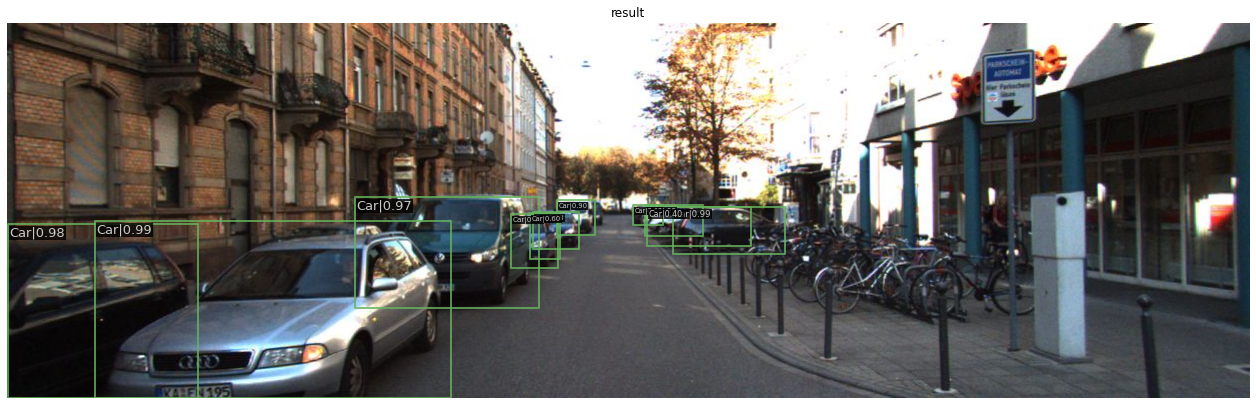

In [34]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg

result = inference_detector(model, img) # BGR이미지를 넣어주어야 함을 반드시 기억하기
show_result_pyplot(model, img, result)

In [35]:
cfg.data.test.pipeline[0].type

'LoadImageFromWebcam'

### 학습된 모델을 이용하여 Video Detection 수행하기

In [36]:
# Object Detection할 target video를 download 받는다
%cd /content
!mkdir /content/data
!wget -O /content/data/the_rock_chase.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true

/content
--2022-08-16 15:44:58--  https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/the_rock_chase.mp4 [following]
--2022-08-16 15:44:58--  https://github.com/chulminkw/DLCV/raw/master/data/video/the_rock_chase.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/the_rock_chase.mp4 [following]
--2022-08-16 15:44:58--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/the_rock_chase.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.

In [37]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
labels_to_names_seq = {i:k for i, k in enumerate(CLASSES)}
labels_to_names_seq

{0: 'Car', 1: 'Truck', 2: 'Pedestrian', 3: 'Cyclist'}

In [38]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}

def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
  # 인자로 들어온 image_array를 복사. 
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음. 
  # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list. 
  results = inference_detector(model, img_array)

  # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화 
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐. 
  for result_ind, result in enumerate(results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행. 
    if len(result) == 0:
      continue
    
    # 2차원 array에서 5번째 컬럼에 해당하는 값이 score threshold이며 이 값이 함수 인자로 들어온 score_threshold 보다 낮은 경우는 제외. 
    result_filtered = result[np.where(result[:, 4] > score_threshold)]
    
    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출. 
    for i in range(len(result_filtered)):
      # 좌상단, 우하단 좌표 추출. 
      left = int(result_filtered[i, 0])
      top = int(result_filtered[i, 1])
      right = int(result_filtered[i, 2])
      bottom = int(result_filtered[i, 3])
      caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i, 4])
      cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
      cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
      if is_print:
        print(caption)

  return draw_img

In [39]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)
    btime = time.time()
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        stime = time.time()
        img_frame = get_detected_img(model, img_frame,  score_threshold=score_threshold, is_print=False)
        if do_print:
          print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

    print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))

In [40]:
do_detected_video(model, '/content/data/the_rock_chase.mp4', '/content/data/the_rock_chase_out1.mp4', score_threshold=0.4, do_print=True)

총 Frame 갯수: 503
frame별 detection 수행 시간: 0.1685
frame별 detection 수행 시간: 0.141
frame별 detection 수행 시간: 0.1125
frame별 detection 수행 시간: 0.1148
frame별 detection 수행 시간: 0.1163
frame별 detection 수행 시간: 0.1212
frame별 detection 수행 시간: 0.1101
frame별 detection 수행 시간: 0.1155
frame별 detection 수행 시간: 0.1104
frame별 detection 수행 시간: 0.1137
frame별 detection 수행 시간: 0.1136
frame별 detection 수행 시간: 0.1178
frame별 detection 수행 시간: 0.1098
frame별 detection 수행 시간: 0.1127
frame별 detection 수행 시간: 0.1151
frame별 detection 수행 시간: 0.1164
frame별 detection 수행 시간: 0.1126
frame별 detection 수행 시간: 0.1135
frame별 detection 수행 시간: 0.1129
frame별 detection 수행 시간: 0.1124
frame별 detection 수행 시간: 0.1129
frame별 detection 수행 시간: 0.1118
frame별 detection 수행 시간: 0.1115
frame별 detection 수행 시간: 0.1135
frame별 detection 수행 시간: 0.1153
frame별 detection 수행 시간: 0.1137
frame별 detection 수행 시간: 0.1122
frame별 detection 수행 시간: 0.116
frame별 detection 수행 시간: 0.1147
frame별 detection 수행 시간: 0.1148
frame별 detection 수행 시간: 0.1129
frame별 detection 수행 시간: 0